In [1]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import sklearn
import sklearn.model_selection
import sklearn.linear_model

import statsmodels.formula.api as smf

# Load data

In [2]:
with open('benchmark-700-v1.pickle', 'rb') as f:
    results = pickle.load(f)
    
df = pd.DataFrame(results)
df["radius2"] = (df.X ** 2 + df.Y ** 2)
df["radius"] = np.sqrt(df["radius2"])
#df["LAUNCH_ANGLE_THRESH_DEG"] = np.rint(df["LAUNCH_ANGLE_THRESH"] / np.pi * 180.0).astype(int)

print(len(df))
df.head()

700


,X,Y,Z,LAUNCH_ANGLE_THRESH,MAX_APPROACH_ANGLE,OBJECT_TO_TOSS,GRIPPER_TO_OBJECT_COM_DIST,land_pos_error,land_angle_error,aim_angle_error,...,land_y,land_z,sim_land_angle,plan_land_angle,plan_launch_angle,release_frac,throw_motion_time,status,radius2,radius
0,-1,1,-3,-0.05236,-0.785398,ball,0.11,0.128040,0.015415,0.000018,...,1.090497,-2.997223,-1.428543,-1.443958,0.672715,0.255723,0.828978,OK,2,1.414214
1,-1,2,-3,-0.05236,-0.785398,ball,0.11,0.353755,0.029200,0.000025,...,2.316343,-2.994677,-1.380337,-1.409537,1.078445,0.417478,0.405088,OK,5,2.236068
2,-1,3,-3,-0.05236,-0.785398,ball,0.11,0.074548,0.012615,0.000013,...,3.070485,-2.994070,-1.264886,-1.277501,0.663398,0.252048,0.343739,OK,10,3.162278
3,-1,4,-3,-0.05236,-0.785398,ball,0.11,-0.080066,0.003051,0.000011,...,3.922380,-2.996696,-1.213481,-1.216532,0.688964,0.262136,0.271021,OK,17,4.123106
4,-1,5,-3,-0.05236,-0.785398,ball,0.11,-0.579892,-0.024426,0.000009,...,4.431363,-2.998347,-1.164892,-1.140466,0.616329,0.233512,0.225539,OK,26,5.099020


In [3]:
print(df.status.unique())
df[df.isna().any(axis=1)]

['OK']


,X,Y,Z,LAUNCH_ANGLE_THRESH,MAX_APPROACH_ANGLE,OBJECT_TO_TOSS,GRIPPER_TO_OBJECT_COM_DIST,land_pos_error,land_angle_error,aim_angle_error,...,land_y,land_z,sim_land_angle,plan_land_angle,plan_launch_angle,release_frac,throw_motion_time,status,radius2,radius
138,-3,4,2,-0.05236,-0.785398,ball,0.11,-0.366966,NaN,0.000010,...,3.706399,2.000389,NaN,-0.823616,1.042248,0.402925,0.155616,OK,25,5.000000
334,-2,5,3,0.00000,-0.785398,ball,0.11,-0.291188,NaN,0.000014,...,4.729612,3.000477,NaN,-0.873882,1.140196,0.442352,0.138913,OK,29,5.385165
438,-3,4,0,0.05236,-0.785398,ball,0.11,-0.297612,NaN,0.000007,...,3.761912,0.003950,NaN,-0.860230,0.758855,0.289792,0.180728,OK,25,5.000000


In [4]:
df = df.dropna()
df.isnull().values.any()

False

In [5]:
df.LAUNCH_ANGLE_THRESH.unique()

array([-0.05235988,  0.        ,  0.05235988,  0.10471976])

In [6]:
df.columns

Index(['X', 'Y', 'Z', 'LAUNCH_ANGLE_THRESH', 'MAX_APPROACH_ANGLE',
       'OBJECT_TO_TOSS', 'GRIPPER_TO_OBJECT_COM_DIST', 'land_pos_error',
       'land_angle_error', 'aim_angle_error', 'time_to_arrival', 'land_time',
       'land_x', 'land_y', 'land_z', 'sim_land_angle', 'plan_land_angle',
       'plan_launch_angle', 'release_frac', 'throw_motion_time', 'status',
       'radius2', 'radius'],
      dtype='object')

### Check if considering only radius is enough 

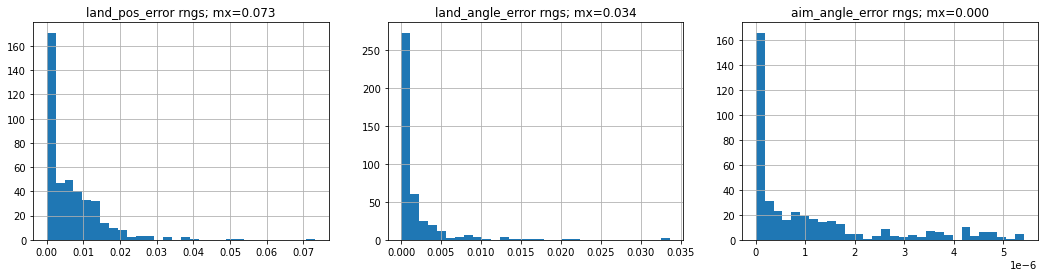

In [7]:
plt.figure(figsize=(18,4))

gb = df.groupby(["LAUNCH_ANGLE_THRESH", "Z", "radius2"]).agg(np.ptp)

for idx, name in enumerate([
    "land_pos_error",
    "land_angle_error",
    "aim_angle_error",
]):
    plt.subplot(1, 3, idx + 1)
    gb[name].hist(bins=30);
    plt.title(f"{name} rngs; mx={gb[name].max():.3f}")

### Distribution of errors launch_thresh

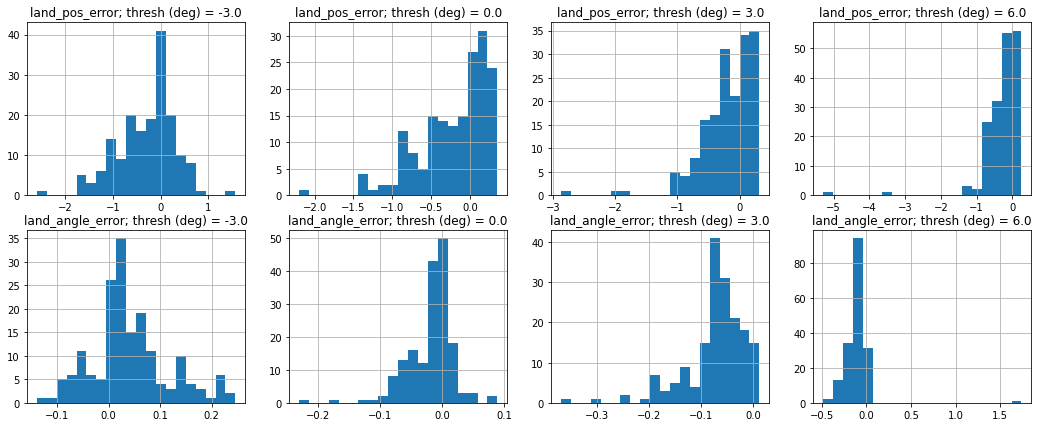

In [8]:
plt.figure(figsize=(18,7))

ERROR_MEASURES = [
    "land_pos_error",
    "land_angle_error",
]
THRESHES = df.LAUNCH_ANGLE_THRESH.unique()

idx = 1
for error_measure in ERROR_MEASURES:
    for thresh in THRESHES:
        plt.subplot(len(ERROR_MEASURES), len(THRESHES), idx)
        df[df.LAUNCH_ANGLE_THRESH == thresh][error_measure].hist(bins=20)
        plt.title(f"{error_measure}; thresh (deg) = {thresh / np.pi * 180.0}")
        
        idx += 1

# Linear model

### Some visualizations of the features

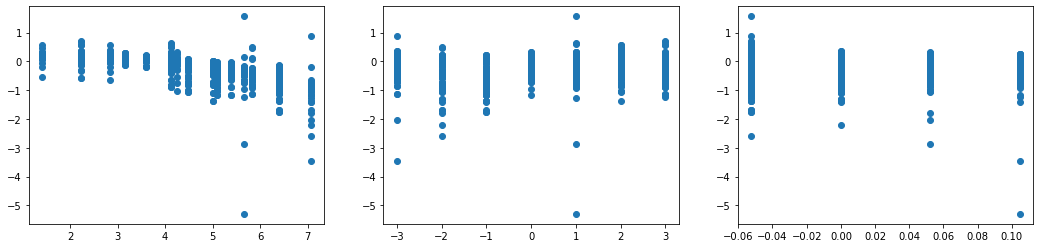

In [9]:
plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.scatter(df["radius"], df.land_pos_error)

plt.subplot(1, 3, 2)
plt.scatter(df.Z, df.land_pos_error);

plt.subplot(1, 3, 3)
plt.scatter(df.LAUNCH_ANGLE_THRESH, df.land_pos_error);

In [10]:
model = smf.ols(
    formula='land_pos_error ~ radius2 + Z + release_frac + throw_motion_time + LAUNCH_ANGLE_THRESH',
    data=df
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         land_pos_error   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     121.3
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           4.65e-92
Time:                        07:23:50   Log-Likelihood:                -311.11
No. Observations:                 697   AIC:                             634.2
Df Residuals:                     691   BIC:                             661.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.2961      0.123     -2.404      0.016      -0.538      -0.054
radius2                -0.0258      0.002    -15.866      0.000      -0.029      -0.023
Z                      -0.0457      0.012     -3.915      0.000      -0.069      -0.023
release_frac            1.6367      0.224      7.293      0.000       1.196       2.077
throw_motion_time       0.2395      0.242      0.989      0.323      -0.236       0.715
LAUNCH_ANGLE_THRESH     0.1964      0.246      0.800      0.424      -0.286       0.679
==============================================================================
Omnibus:                      778.338   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96530.080
Skew:                          -5.065   Prob(JB):                         0.00
Kurtosis:                      59.756   Cond. No.                         494.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
model = smf.ols(
    formula='LAUNCH_ANGLE_THRESH ~ radius2 + Z + release_frac + throw_motion_time + land_pos_error',
    data=df
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LAUNCH_ANGLE_THRESH   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.006
Method:                  Least Squares   F-statistic:                    0.1292
Date:                 Fri, 11 Dec 2020   Prob (F-statistic):              0.986
Time:                         07:23:52   Log-Likelihood:                 989.04
No. Observations:                  697   AIC:                            -1966.
Df Residuals:                      691   BIC:                            -1939.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0274      0.019      1.434      0.152      -0.010       0.065
radius2               0.0001      0.000      0.433      0.665      -0.000       0.001
Z                     0.0003      0.002      0.170      0.865      -0.003       0.004
release_frac         -0.0077      0.036     -0.213      0.831      -0.078       0.063
throw_motion_time    -0.0006      0.038     -0.016      0.987      -0.074       0.073
land_pos_error        0.0047      0.006      0.800      0.424      -0.007       0.016
==============================================================================
Omnibus:                     4234.046   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.423
Skew:                           0.005   Prob(JB):                     2.51e-12
Kurtosis:                       1.644   Cond. No.                         501.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
X = pd.DataFrame(df[["radius2", "Z", "LAUNCH_ANGLE_THRESH"]])
y = pd.DataFrame(df["land_pos_error"])
X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=41)
)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.33897477703925216